# Algoritmos de Predicción

Importación de librerías

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
from sklearn.metrics import accuracy_score,recall_score,f1_score,precision_score,classification_report, confusion_matrix

Carga de la data:

In [2]:
df1 = pd.read_csv('df1_3.csv', header=0)
df2 = pd.read_csv('df2_3.csv', header=0)

Los algoritmos de predicción utilizados serán:
* Random Forest
* Logistic Regression
* KNN
* AdaBoost
* XGBoost
* C5.0
* Support Vector Machine

In [3]:
# División de los conjuntos de datos
X_train = df1.drop("class", axis=1)
X_test = df2.drop("class", axis=1)
y_train = df1["class"]
y_test = df2["class"]

# Verificar las dimensiones de los conjuntos de datos
print("Dimensiones de X_train:", X_train.shape)
print("Dimensiones de X_test:", X_test.shape)
print("Dimensiones de y_train:", y_train.shape)
print("Dimensiones de y_test:", y_test.shape)

Dimensiones de X_train: (60000, 162)
Dimensiones de X_test: (16000, 162)
Dimensiones de y_train: (60000,)
Dimensiones de y_test: (16000,)


In [4]:
classifier=[]
imported_as=[]

#ADA
from sklearn.ensemble import AdaBoostClassifier
ada = AdaBoostClassifier()
classifier.append('Ada Boost')
imported_as.append('ada')

#XGB
import xgboost as xgb
from xgboost import XGBClassifier
ratio = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
xgb_params = {
    'max_depth': 6,
    'learning_rate': 0.05, # eta
    'n_estimators': 398,
    'subsample': 0.6, # subsample
    'colsample_bytree': 1, # colsample_bytree
    'reg_lambda': 1.0, # lambda
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'scale_pos_weight': ratio  # Utilizar el cociente como valor de scale_pos_weight
}
xgb = xgb.XGBClassifier(**xgb_params)
classifier.append('XG Boost')
imported_as.append('xgb')

# Logistic Regression
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
classifier.append('Logistic Regression')
imported_as.append('lr')

#RFC
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
classifier.append('Random Forest')
imported_as.append('rfc')

#KNN
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=1)
classifier.append('k Nearest Neighbours')
imported_as.append('knn')

#SVM
from sklearn.svm import SVC
svc = SVC()
classifier.append('Support Vector Machine')
imported_as.append('svc')

classifiers = pd.DataFrame({'Classifier':classifier,'Imported as':imported_as})
print('All Models Imported\nModels stored in dataframe called classifiers')

All Models Imported
Models stored in dataframe called classifiers


In [5]:
class Modelling:
    def __init__(self, X_train, Y_train, X_test, Y_test, models):
        self.X_train = X_train
        self.X_test = X_test
        self.Y_train = Y_train
        self.Y_test = Y_test
        self.models = models
    
    def fit(self):
        model_acc = []
        model_f1 = []
        model_recall = []
        model_precision = []
        model_fn = []
        model_fp = []
        model_time= []

        for i in self.models:
            start=time.time()
            if i == 'knn':
                accuracy = []
                for j in range(1,200):    
                    kn = KNeighborsClassifier(n_neighbors=j)
                    kn.fit(self.X_train,self.Y_train)
                    predK = kn.predict(self.X_test)
                    accuracy.append([accuracy_score(self.Y_test,predK),j])
                temp = accuracy[0]
                for m in accuracy:
                    if temp[0] < m[0]:
                        temp=m
                i = KNeighborsClassifier(n_neighbors=temp[1])
            i.fit(self.X_train,self.Y_train)
            y_pred = i.predict(self.X_test)
            model_acc.append(accuracy_score(self.Y_test, y_pred))
            model_f1.append(f1_score(self.Y_test, y_pred))
            model_recall.append(recall_score(self.Y_test, y_pred))
            model_precision.append(precision_score(self.Y_test, y_pred))
            
            tn, fp, fn, tp = confusion_matrix(self.Y_test, y_pred).ravel()
            model_fn.append(fn)
            model_fp.append(fp)
            
            stop=time.time()
            model_time.append((stop-start))
            print(i,'has been fit')
        self.models_output = pd.DataFrame({'Models':self.models,
                                   'Accuracy': model_acc,
                                   'F1-Score': model_f1,
                                   'Recall': model_recall,
                                   'Precision': model_precision,
                                   'False Negatives': model_fn,
                                   'False Positives': model_fp,
                                   'Runtime (s)': model_time})

        
    def results(self):
        models = self.models_output
        models = models.sort_values(by=['Accuracy', 'Runtime (s)'], ascending=[False, True]).reset_index().drop('index', axis=1)
        self.best = models['Models'][0]
        models['Models'] = models['Models'].astype(str).str.split("(", n=2, expand=True)[0]
        models['Accuracy'] = models['Accuracy'].round(5) * 100
        models['F1-Score'] = models['F1-Score'].round(5) * 100
        models['Recall'] = models['Recall'].round(5) * 100
        models['Precision'] = models['Precision'].round(5) * 100
        models['Maintenance_Cost'] = models['False Negatives'] * 500 + models['False Positives'] * 10
        self.models_output_cleaned = models
        return models

        
    def best_model(self,type):
        if type=='model':
            return(self.best)
        elif type=='name':
            return(self.models_output_cleaned['Models'][0])
    
    def best_model_accuracy(self):
        return(self.models_output_cleaned['Accuracy'][0])
    
    def best_model_runtime(self):
        return(round(self.models_output_cleaned['Runtime (s)'][0],3))
    
    def best_model_predict(self,X_test):
        return(self.best.predict(X_test))
    
    def best_model_clmatrix(self):
        return(classification_report(self.Y_test,self.best.predict(self.X_test)))

In [6]:
display(classifiers)

,Classifier,Imported as
0,Ada Boost,ada
1,XG Boost,xgb
2,Logistic Regression,lr
3,Random Forest,rfc
4,k Nearest Neighbours,knn
5,Support Vector Machine,svc


In [7]:
models_to_test = [ada,xgb,rfc,lr,knn,svc]

In [8]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 162 entries, aa_000 to eg_000
dtypes: float64(162)
memory usage: 74.2 MB


In [9]:
classification = Modelling(X_train,y_train,X_test,y_test,models_to_test)
classification.fit()

AdaBoostClassifier() has been fit
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=398, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...) has been fit
RandomForestClassifier() has been fit
LogisticRegression() has been fit
KNeighborsClassifier(n_neighbors=1) has been fit
SVC() has been fit


In [10]:
classification.results()

,Models,Accuracy,F1-Score,Recall,Precision,False Negatives,False Positives,Runtime (s),Maintenance_Cost
0,XGBClassifier,99.275,84.574,84.800,84.350,57,59,42.862600,29090
1,RandomForestClassifier,99.219,81.089,71.467,93.706,107,18,58.435436,53680
2,SVC,98.956,74.028,63.467,88.806,137,30,26.491648,68800
3,AdaBoostClassifier,98.862,73.851,68.533,80.062,118,64,36.391243,59640
4,LogisticRegression,98.631,64.734,53.600,81.707,174,45,1.365360,87450
5,KNeighborsClassifier,98.550,64.955,57.333,74.913,160,72,12.928891,80720


In [21]:
header = classification.results()

# Guardar el encabezado como un archivo XLSX
header.to_excel('classification_results.xlsx', index=False)

In [11]:
print('BestModel is:',  classification.best_model(type='name'))
print('Accuracy of model:',classification.best_model_accuracy())
print('Training Runtime in seconds',classification.best_model_runtime())
print('Classification Matrix:\n')
print(classification.best_model_clmatrix())

BestModel is: XGBClassifier
Accuracy of model: 99.275
Training Runtime in seconds 42.863
Classification Matrix:

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     15625
         1.0       0.84      0.85      0.85       375

    accuracy                           0.99     16000
   macro avg       0.92      0.92      0.92     16000
weighted avg       0.99      0.99      0.99     16000



c:\Users\diego\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


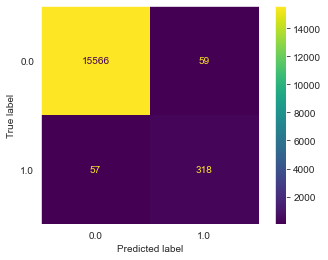

In [12]:
sns.set_style("darkgrid", {"grid.color": "1", "grid.linestyle": " "})

from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(classification.best_model(type='model'), X_test, y_test) 

In [16]:
from sklearn.metrics import confusion_matrix, classification_report

# Crear listas para almacenar las matrices de confusión y las tablas de resultados
confusion_matrices = []
classification_reports = []

for model in models_to_test:
    # Entrenar el modelo en el conjunto de entrenamiento
    model.fit(X_train, y_train)
    
    # Predecir en el conjunto de prueba
    y_pred = model.predict(X_test)
    
    # Calcular la matriz de confusión
    confusion = confusion_matrix(y_test, y_pred)
    
    # Calcular el informe de clasificación
    report = classification_report(y_test, y_pred)
    
    # Agregar la matriz de confusión y el informe de clasificación a las listas
    confusion_matrices.append(confusion)
    classification_reports.append(report)

# Ahora, confusion_matrices y classification_reports contienen las matrices de confusión
# y los informes de clasificación para cada modelo en models_to_test


Matriz de Confusión para el Modelo AdaBoostClassifier:


c:\Users\diego\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


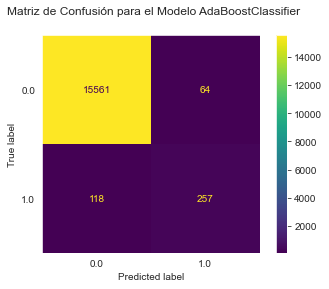

Matriz de Confusión para el Modelo XGBClassifier:


c:\Users\diego\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


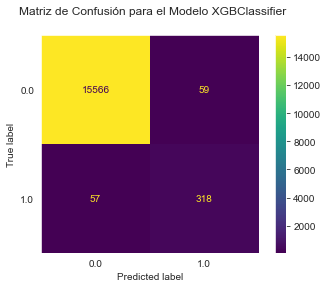

Matriz de Confusión para el Modelo RandomForestClassifier:


c:\Users\diego\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


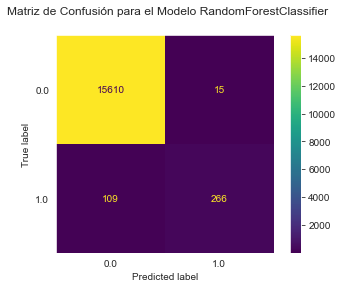

Matriz de Confusión para el Modelo LogisticRegression:


c:\Users\diego\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


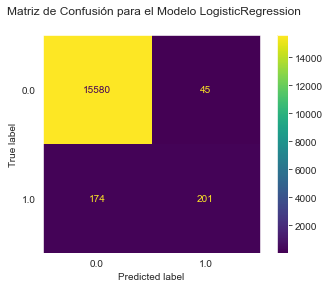

Matriz de Confusión para el Modelo KNeighborsClassifier:


c:\Users\diego\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


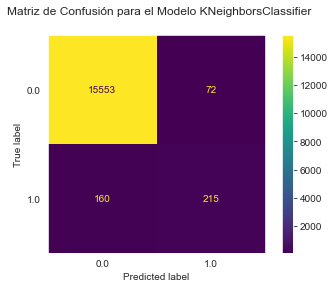

Matriz de Confusión para el Modelo SVC:


c:\Users\diego\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


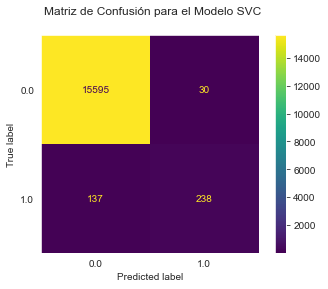

In [20]:
from sklearn.metrics import plot_confusion_matrix

# Visualizar matrices de confusión para cada modelo
for model in models_to_test:
    model_name = type(model).__name__  # Obtiene el nombre del modelo
    print(f"Matriz de Confusión para el Modelo {model_name}:")
    disp = plot_confusion_matrix(model, X_test, y_test)
    disp.figure_.suptitle(f'Matriz de Confusión para el Modelo {model_name}')
    plt.show()
